# Exercise: Feature selection - imbalance price prediction

In this exercise, we will use linear regression to predict imbalance prices using features such as past prices, day-ahead prices, renewable dispatch, and others.

## 1 - Time series prediction using past prices
In this section, we will use only the past price as features to predict the next imbalance price. For instance, to predict the price at time t, we can use the last n price realisations for slots t-n, ..., t-1 as features and fit a linear regressor. 

Now, we describe the metric used. Mean squared error (MSE) is simply the mean of the sum of squared errors (duh). Sum of squared errors is what you use as a loss function to train the linear regressor.
$$
\text{MSE} = \sum_{i=1}^T \frac{ (y_i - f_i)^2}{T}
$$

R2 is a score between 0 and 1, which represents the proportion of variance explained by our trained model, defined below.
$$
\text{R}^2 = 1-\frac{\sum(y_i-f_i)^2}{\sum(y_i-\bar{y})^2},
$$
where $\bar{y}$ is mean of the observed data, and $f_i$ is our prediction. Mean absolute error (MAE) is defined below.
$$
\text{MAE} = \sum_{i=1}^T \frac{\lvert y_i - f_i \rvert}{T}
$$

### Tasks

- First, let us prepare the data from the given dataset. The dataset provides us with prices for T slots. Prepare features and targets for a look back window of size n?
- Split the dataset into training and testing sets.
- Train a linear regressor and evaluate it on the test set using rmse, and mae metrics.
- How good is the performance?

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

def get_data(N):
    # -------------------------------------------------------------------------
    # Load the dataset and preprocess it to create a supervised learning problem.
    df = pd.read_csv("imbalance_price_features_2025_06.csv", )
    T = len(df)
    data_dict = {f"t-{N+1-n}": df["Imbalance price"].values[n-1:T-N+n-1] for n in range(1, N+1)}
    data_dict["t"] = df["Imbalance price"].values[N:T]
    data_dict["Slot Id"] = df["Slot Id"].values[N:T]
    data = pd.DataFrame(columns=['Slot Id'] + [f"t-{N+1-n}" for n in range(1, N+1)] + ["t"], data=data_dict)
    return data

def train_lin_regressor(data: pd.DataFrame, drop = [], reg = 1):
    """
    Trains a linear regressor to predict 'Imbalance price' using all the other features in the dataset, dropping the features in the 'drop' list.
    """
    # -------------------------------------------------------------------------
    # Split the dataset into training and testing sets. Scikit-learn offers a train_test_split function, check documentation.
    train_df, test_df = train_test_split(data.drop(columns=drop), test_size=0.2, random_state=42, shuffle=False)

    # -------------------------------------------------------------------------
    # Train a linear regression model on the training set and evaluate it on the test set.
    model = Lasso(alpha=reg)
    model.fit(train_df.drop(columns=["Slot Id", "t"]), train_df["t"])
    
    return model, test_df

def evaluate(test_df, model, N=0, plot=True):
    # -------------------------------------------------------------------------
    # Evaluate the model
    preds = model.predict(test_df.drop(columns=["Slot Id", "t"]))
    mse = root_mean_squared_error(test_df["t"], preds)
    mae = mean_absolute_error(test_df["t"], preds)
    r2 = r2_score(test_df["t"], preds)

    if plot:
        plt.plot(test_df["t"].values, label="True Prices")
        plt.plot(preds, label="Predicted Prices")
        plt.legend()
        plt.xlabel("Slot")
        plt.ylabel("Imbalance price")
        plt.title(f"N={N}")
        plt.ylim(-500, 500)
        plt.xlim(0, 200)
        plt.show()

    return {'mse': mse, 'mae': mae, 'r2': r2, 'coef': model.coef_, 'intercept': model.intercept_}

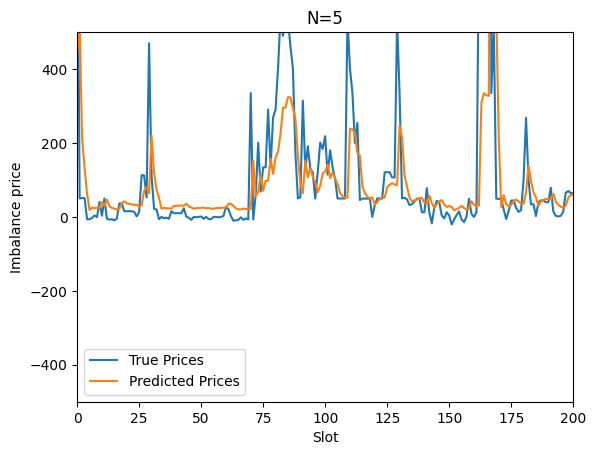

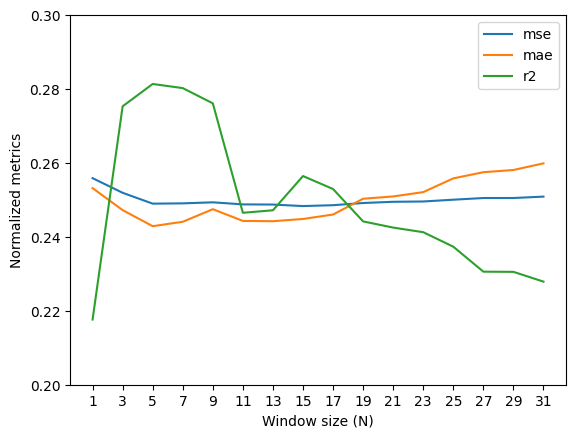

Metrics for the best model (N=5):
MSE: 242.51086075494618
MAE: 74.1175244871865
R2: 0.13436085582424695


In [2]:
import numpy as np

# Analyze the effect of the window size N on the model performance
metrics = {'mse': [], 'mae': [], 'r2': []}
set_N = np.linspace(1, 31, 16, dtype=int)
for N in set_N:
    data = get_data(N)
    model, test_df = train_lin_regressor(data)
    if N == 5:
        metric = evaluate(test_df, model, N=5, plot=True)
    else:
        metric = evaluate(test_df, model, plot=False)
    [metrics[key].append(metric[key]) for key in metrics]

[plt.plot(np.array(metrics[key])/np.linalg.norm(metrics[key]), label=key) for key in metrics]
plt.xlabel("Window size (N)")
plt.ylabel("Normalized metrics")
plt.xticks(range(len(metrics['mse'])), set_N)
plt.legend()
plt.ylim(0.2, 0.3)
plt.show()

print("Metrics for the best model (N=5):")
print(f"MSE: {metrics['mse'][2]}")
print(f"MAE: {metrics['mae'][2]}")
print(f"R2: {metrics['r2'][2]}")

# 2 - Time series prediction with external features
Since, the imbalance price is affected by other market quantities, we include external features to improve our model. Note that, only features that are available a-priori to the delivery time are valid features, since prediction model needs to be run before delivery time. For instance, imbalance price depends on the system imbalance which is impacted by the share of non-controllable renewable resources like wind power. Thus, wind forecast might be a useful feature to include. Moreover, the imbalance price is also correlated with the day-ahead price.

### Tasks
- Now, use other features in the dataset as well. Try to find a nice set of features that are useful.
- What do the linear coefficients corresponding to each feature represent? Can we conclude that the smaller the coefficient, smaller is the correlation - think?
- Did you get a lot of improvement by adding new features? What is the drawback of adding more features - think computational complexity?

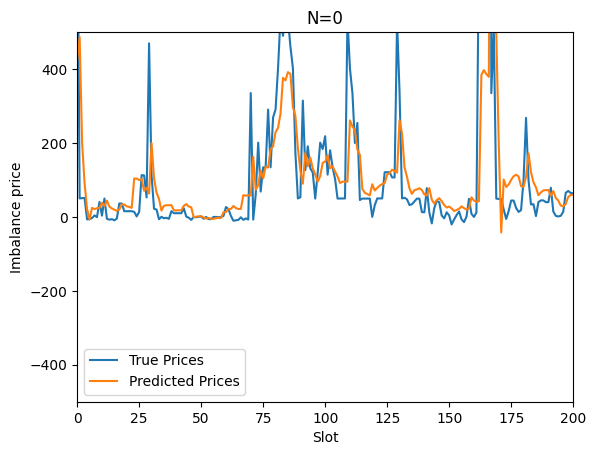

      Slot Id     t-5     t-4     t-3     t-2     t-1       t  DA price  Wind  \
2300     2306  110.65   59.33  108.76  243.34  998.58  998.58     50.00  1087   
2301     2307   59.33  108.76  243.34  998.58  998.58   50.00     50.00  1045   
2302     2308  108.76  243.34  998.58  998.58   50.00   50.89     50.00  1038   
2303     2309  243.34  998.58  998.58   50.00   50.89   51.15     51.15  1062   
2304     2310  998.58  998.58   50.00   50.89   51.15   -6.60     51.15  1074   
...       ...     ...     ...     ...     ...     ...     ...       ...   ...   
2870     2876  359.05  233.35   52.00   52.42  157.00   50.34    157.00    35   
2871     2877  233.35   52.00   52.42  157.00   50.34  122.65    122.65    33   
2872     2878   52.00   52.42  157.00   50.34  122.65  122.65    122.65    33   
2873     2879   52.42  157.00   50.34  122.65  122.65  122.65    122.65     6   
2874     2880  157.00   50.34  122.65  122.65  122.65  122.65     11.00    11   

      Biomass  Fossil Gas  

In [3]:
def get_data_ex_features(N):
    df = pd.read_csv("imbalance_price_features_2025_06.csv")
    data = get_data(N)
    data = data.merge(df.drop(columns=["Time slot", "Imbalance price"]), on="Slot Id")
    return data

N = 5
data = get_data_ex_features(N)
model, test_df = train_lin_regressor(data, drop=[], reg=1)
metric = evaluate(test_df, model)
print(test_df)
print(metric)

## 3 - Time series prediction with polynomial regression
Recall polynomial regression from previous exercise. Here, we want to do the same for our problem

### Tasks
- How is the performance with polynomial features? If it decreases, then why is it so?
- See if regularization helps, how can you increase regularization?
- In case of Lasso regression, observe that it results in automatic feature selection, how?

In [4]:
from sklearn.preprocessing import PolynomialFeatures

def train_poly(data, drop = [], reg = 1):

    # -------------------------------------------------------------------------
    # Split the dataset into training and testing sets. Scikit-learn offers a train_test_split function, check documentation.
    poly = PolynomialFeatures(degree=2, include_bias=True)
    features = poly.fit_transform(data.drop(columns=["Slot Id", "t"]+drop))
    targets = data["t"].values
    train_features, test_features, train_targets, test_targets = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=False)

    # -------------------------------------------------------------------------
    # Train a linear regression model on the training set and evaluate it on the test set.
    model = Lasso(reg, max_iter=10000)
    model.fit(train_features, train_targets)
    
    return model, test_targets, test_features

def evaluate_poly(test_features, test_targets, model, plot=True):
    # -------------------------------------------------------------------------
    # Evaluate the model
    preds = model.predict(test_features)
    mse = root_mean_squared_error(test_targets, preds)
    mae = mean_absolute_error(test_targets, preds)
    r2 = r2_score(test_targets, preds)

    if plot:
        plt.plot(test_targets, label="True Prices")
        plt.plot(preds, label="Predicted Prices")
        plt.legend()
        plt.xlabel("Slot")
        plt.ylabel("Imbalance price")
        plt.ylim(-500, 500)
        # plt.xlim(1000, 1200)
        plt.show()

    return {'mse': mse, 'mae': mae, 'r2': r2, 'coef': model.coef_, 'intercept': model.intercept_}
    

/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+07, tolerance: 5.332e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+07, tolerance: 5.332e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to inc

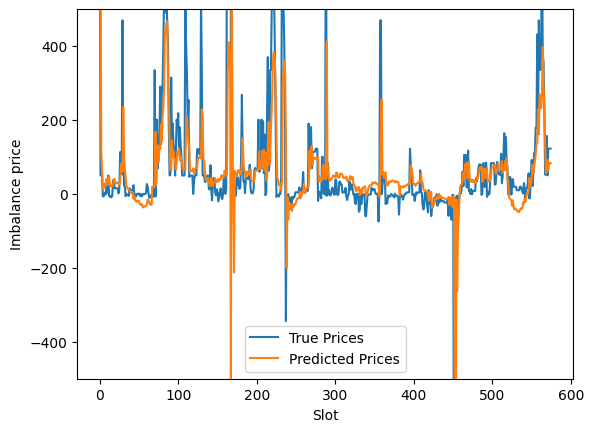

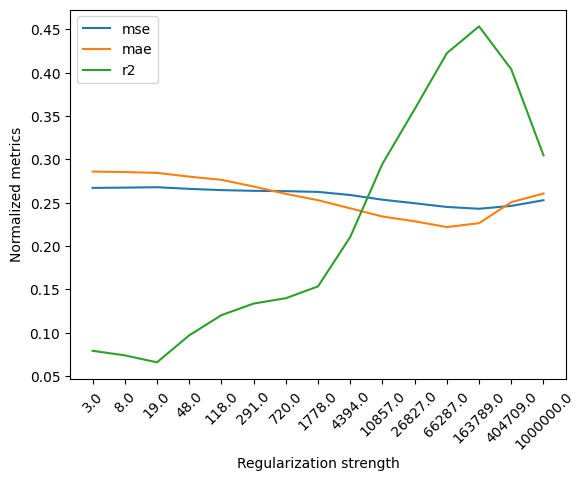

Metrics for the best model (reg=66287):
MSE: 232.97168625558336
MAE: 71.1186498400947
R2: 0.20112140101321052


In [5]:
N = 5
data = get_data_ex_features(N)

metrics = {'mse': [], 'mae': [], 'r2': []}
set_reg = np.logspace(0.5, 6, 15)
for i, reg in enumerate(set_reg):
    model, test_targets, test_features = train_poly(data, drop=[], reg=reg)
    if i == 12:
        metric = evaluate_poly(test_features, test_targets, model, True)
    else:
        metric = evaluate_poly(test_features, test_targets, model, False)
    [metrics[key].append(metric[key]) for key in metrics]

[plt.plot(np.array(metrics[key])/np.linalg.norm(metrics[key]), label=key) for key in metrics]
plt.xlabel("Regularization strength")
plt.ylabel("Normalized metrics")
plt.xticks(range(len(metrics['mse'])), np.round(set_reg, 0), rotation=45)
plt.legend()
# plt.ylim(0.2, 0.3)
plt.show()

print("Metrics for the best model (reg=66287):")
print(f"MSE: {metrics['mse'][12]}")
print(f"MAE: {metrics['mae'][12]}")
print(f"R2: {metrics['r2'][12]}")